In [1]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
############ EVALUATE HUB-HEIGHT HURRICANE STATISTICS RELEVANT FOR ############
#################### IEC STANDARD FOR ALL HURRICANES  #########################
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [2]:
#%% Define file locations
## BLANCA
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_28_skipd01_skipCoLES_ndg/"

## KESTREL
WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_30_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_27real_skipd01_skipCoLES_ndg/"

# Choose which domain to evaluate
domain = 'd02'

# Whether or not to save figures
saveFig = 'False'

# Decide whether or not to save 1-min wind speed
saveCat = 'True'

# Decide whether or not to interpolate to z=10m
interp_to10 = 'False'

# Time series output for each restart
restarts = '.' # timeSeries_d03


# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')
startTime_dom = np.datetime64('2000-01-06T10:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 5


In [3]:
#%% Extract data for domain size
# Find auxHist files for current domain
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

# entries = ["auxHist24_d03_2000-01-06_12:25:30","auxHist24_d02_2000-01-06_12:35:30"]
# rndmFromInterest = 0

entries = ["auxHist24_d02_2000-01-06_15:32:30"]
rndmFromInterest = 0

print(entries[rndmFromInterest])


# Extract data from auxHist file
ds = xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
u = ds['U']
u = np.array(u[0,:,:,:])
v = ds['V']
v = np.array(v[0,:,:,:])
w = ds['W']
w = np.array(w[0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,0:np.shape(u)[2]-1]+u[:,:,1:np.shape(u)[2]])
u = 0.0
v_des = 0.5*(v[:,0:np.shape(v)[1]-1,:]+v[:,1:np.shape(v)[1],:])
v = 0.0
# horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
u_des = 0.0
v_des = 0.0
# Time
Time_3d = ds['Times']
a = str(np.array(Time_3d)[0])
ttime_3d = np.datetime64(a[2:12] + str(' ')+ a[13:-1])
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[2])
n_y = dx*np.arange(0,np.shape(uv)[1])

# Save some memory
uv = uv[0:10,:,:]
w = w[0:10,:,:]

ds.close()


auxHist24_d02_2000-01-06_15:32:30


In [4]:
# Time series locations
# Station locations
locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(2,3)) # [i,j]
name_locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(1),dtype='U')

# Turbine specifications
D = 126 #240
z_hh = 90 #150
rated_ws = 11.4

locs = locs[0:300,:]

print("Done extracting data from general variables")


Done extracting data from general variables


In [5]:
#%% Define use for each station
# Define number of "stations" for high-temporal resolution data 
if domain=='d05':
    which_stations = 'hi'
elif domain=='d04':
#     which_stations = 'lol'
    which_stations = 'd4'
elif domain=='d03':
    which_stations = 'd'
elif domain=='d02':
    which_stations = 'd3'

# Remove time series locations that are not going to be used in analysis
stations = []
for i in np.arange(len(name_locs)):
    if which_stations in name_locs[i]:
        stations = np.append(stations,i)
stations = stations.astype('int')
# stations = stations[:9]
# stations = stations[::9]
# stations = stations[18:63:2]
# stations = stations[85:100]
# stations = stations[18:11*9]
print(stations)
locs = locs[stations]
name_locs = name_locs[stations]
print(name_locs)

# Remove time series locations that are incorrect
if domain=='d05':
    stats = []
    for i in np.arange(len(name_locs)):
        if not locs[i,0] == locs[i,1]:
            stats = np.append(stats,i)       
    stats = stats.astype('int')
    print(stats)
    locs = locs[stats]
    name_locs = name_locs[stats]
    print(name_locs)

locs = locs.astype('int')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

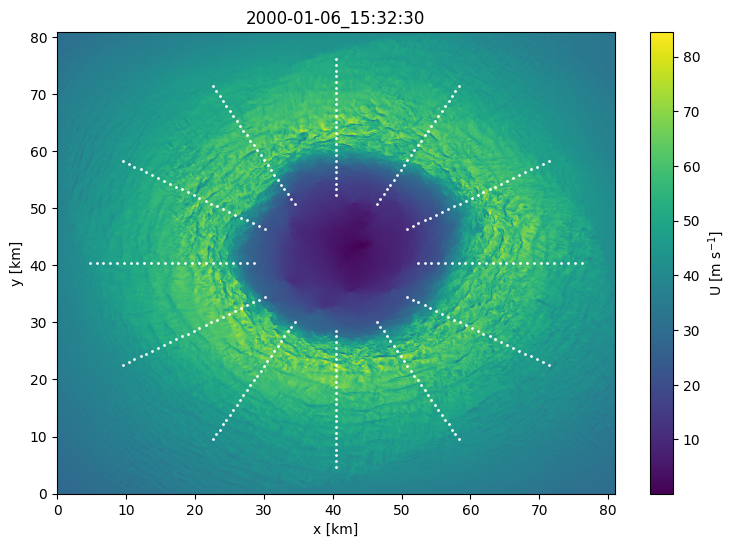

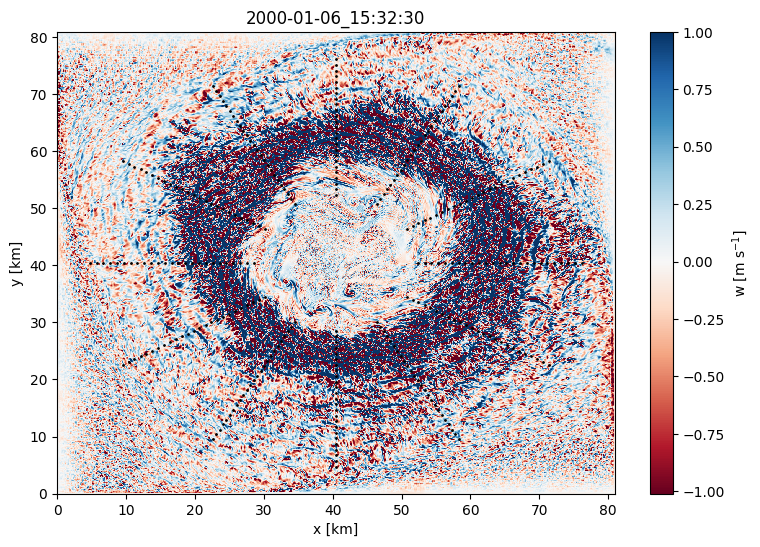

In [6]:
#%% Show relative locations of met tower in the domain
iz = 7

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
minn = -1.01 #np.min(w[iz,:,:])
maxx = 1.0 #np.max(w[iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w[iz,:,:],vmin=minn,vmax=maxx,cmap=newCmap)
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='black')
cbar = plt.colorbar(im1)
cbar.set_label("w [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


In [7]:
#%% Extract high-temporal resolution data
# Time arrays
temp = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.UU',skiprows=1)
temp = temp[0:-200,:]
init_temp = temp[:,0]
time = temp[::ss,0]*(3600/1) # seconds since start of simulation
time_sinceRst = time - time[0] # seconds since initialization
TIME = startTime + time.astype('timedelta64[s]')

# Height array
GHT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))

# Initialize arrays [station,valForEachTimeStep,height]
U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# W = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# theta = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])

# Extract data for each station
for i_s in np.arange(0,len(locs)):
    # Load data
    tempU = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
    tempV = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
#     tempW = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.WW',skiprows=1)
#     tempT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.TH',skiprows=1)
    # Save data
    U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
    V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]
#     W[i_s,:,:] = tempW[:np.shape(init_temp)[0]:ss,1:]
#     theta[i_s,:,:] = tempT[:np.shape(init_temp)[0]:ss,1:]

    print('Done with %i out of %i' % (i_s,len(locs)-1))

# Release memory
tempU = 0.0
tempV = 0.0
# tempW = 0.0

print("Done extracting high-temporal resolution data")


Done with 0 out of 299
Done with 1 out of 299
Done with 2 out of 299
Done with 3 out of 299
Done with 4 out of 299
Done with 5 out of 299
Done with 6 out of 299
Done with 7 out of 299
Done with 8 out of 299
Done with 9 out of 299
Done with 10 out of 299
Done with 11 out of 299
Done with 12 out of 299
Done with 13 out of 299
Done with 14 out of 299
Done with 15 out of 299
Done with 16 out of 299
Done with 17 out of 299
Done with 18 out of 299
Done with 19 out of 299
Done with 20 out of 299
Done with 21 out of 299
Done with 22 out of 299
Done with 23 out of 299
Done with 24 out of 299
Done with 25 out of 299
Done with 26 out of 299
Done with 27 out of 299
Done with 28 out of 299
Done with 29 out of 299
Done with 30 out of 299
Done with 31 out of 299
Done with 32 out of 299
Done with 33 out of 299
Done with 34 out of 299
Done with 35 out of 299
Done with 36 out of 299
Done with 37 out of 299
Done with 38 out of 299
Done with 39 out of 299
Done with 40 out of 299
Done with 41 out of 299
Do

In [8]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])

print(dt)


0.30092570958453213


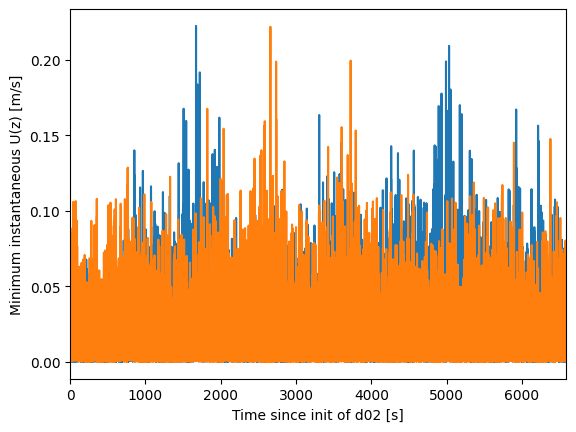

In [9]:
#%% Find virtual met-towers with wrong data

# Define wrong/corrupted conditions
u_vel = 0.0
v_vel = 0.0

# Find stations with wrong data
i_stat_wrong = np.zeros(np.shape(locs)[0])
for i_s in np.arange(np.shape(locs)[0]):
    # Compare wind fields at each station with wrong conditions
    wheres_u = np.where(U[i_s,:,:]==u_vel)[0]
    wheres_v = np.where(V[i_s,:,:]==v_vel)[0]
    if (len(wheres_u)>0):
        i_stat_wrong[i_s] = 1
        for iz in np.arange(len(hgt_agl)):
            tmp_where = np.where(U[i_s,:,iz]==u_vel)[0]
            if (len(tmp_where)>0):
                for ii_tt in tmp_where:
                    U[i_s,ii_tt,iz] = U[i_s,ii_tt-1,iz]
#                 U[i_s,tmp_where[:],iz] = np.nan
    if (len(wheres_v)>0):
        i_stat_wrong[i_s] = 1
        for iz in np.arange(len(hgt_agl)):
            tmp_where = np.where(V[i_s,:,iz]==v_vel)[0]
            if (len(tmp_where)>0):
                for ii_tt in tmp_where:
                    V[i_s,ii_tt,iz] = V[i_s,ii_tt-1,iz]
#                 V[i_s,tmp_where[:],iz] = np.nan
i_stat_wrong = i_stat_wrong.astype('int')

# Fiugre showing time series
plt.figure()
# plt.plot(time_sinceRst,np.nanmin(UV[:,:,:],axis=(0,2)))
plt.plot(time_sinceRst,np.nanmin(np.abs(U[:,:,:]),axis=(0,2)))
plt.plot(time_sinceRst,np.nanmin(np.abs(V[:,:,:]),axis=(0,2)))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Minimum instantaneous U(z) [m/s]')
plt.show()
plt.close()

In [10]:
#%% Calculate horizontal wind speed and wind direction using time series output
# Calculate horizontal wind speed
UV = np.sqrt(U**2 + V**2)

# Calculate horizontal wind direction
wDir = np.zeros(np.shape(U))

for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        uu = np.zeros_like(U[i_s,:,iz]) + U[i_s,:,iz]
        vv = np.zeros_like(V[i_s,:,iz]) + V[i_s,:,iz]
#         vv[vv==0] = 0.1
#         wDir[i_s,:,iz] = np.arctan(uu/vv)*180/np.pi
        wDir[i_s,:,iz] = np.arctan2(vv,uu)*180/np.pi
        
# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180

# Clear memory
U = 0.0
V = 0.0
uu = 0
vv = 0



In [11]:
#%% Load data for temporal evolution of hurricane center for each height
# if domain == 'd03':
#     center_x = np.array([61324.50802739,53372.36928984]) #np.zeros(len(time_sinceRst)) + 52785.38902399
#     center_y = np.array([67166.13973252,56137.35728448]) #np.zeros(len(time_sinceRst)) + 54261.34061233
#     time_center_sinceRst = np.array([time_sinceRst[0], time_sinceRst[-1]]) #time_sinceRst + 0.0
    
#     center_x = np.array([np.mean(n_x),np.mean(n_x)])
#     center_y = np.array([np.mean(n_y),np.mean(n_y)])

center_x = np.array([43090.31163931,43090.31163931]) #np.zeros(len(time_sinceRst)) + 52785.38902399
center_y = np.array([43625.03428173,43625.03428173]) #np.zeros(len(time_sinceRst)) + 54261.34061233
time_center_sinceRst = np.array([time_sinceRst[0], time_sinceRst[-1]]) #time_sinceRst + 0.0
    
# arr_x = np.loadtxt(WRF_DIRECTORY + '/center_x.txt',skiprows=1,delimiter=',')
# arr_y = np.loadtxt(WRF_DIRECTORY + '/center_y.txt',skiprows=1,delimiter=',')

# time_center = arr_x[:,0]
# time_center_sinceRst = time_center - time_center[0]
# center_x = arr_x[:,1:]
# center_y = arr_y[:,1:]
    

Text(0, 0.5, 'r [km]')

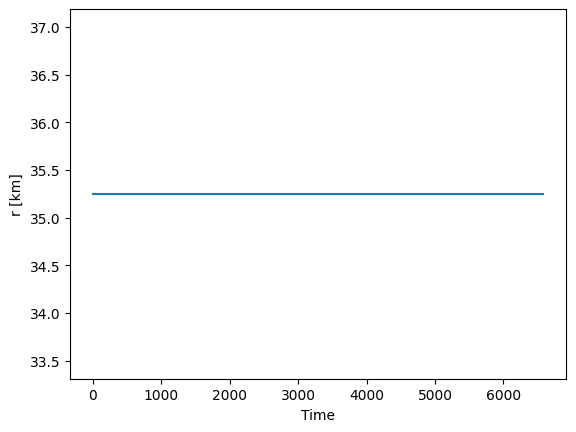

In [12]:
#%% Estimate temporal evolution of radial distance for each time series location at one height
radial_dist = np.zeros([len(time_center_sinceRst),np.shape(locs)[0]])
iz = 0

for it in np.arange(len(time_center_sinceRst)):
    if len(np.shape(center_x))==1:
        radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it])**2 + (n_y[locs[:,1]] - center_y[it])**2)**0.5
    else:
        radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it,iz])**2 + (n_y[locs[:,1]] - center_y[it,iz])**2)**0.5

# Time series of radial distance for a given met-tower at one height
plt.figure()
plt.plot(time_center_sinceRst,radial_dist[:,-1]/1000)
plt.xlabel('Time')
plt.ylabel('r [km]')

Text(0, 0.5, 'r [km]')

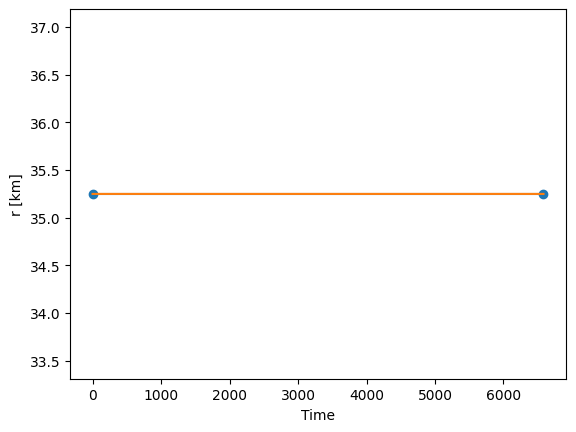

In [13]:
#%% Interpolate data in time to match time series output
# if domain=='d04':
#     # Interpolate center of hurricane at each height
#     center = np.zeros([len(time_sinceRst),np.shape(center_x)[1],2]) # [time, height, x or y center location]
#     for i_z in np.arange(np.shape(center_x)[1]):
#         center[:,i_z,0] = np.interp(time_sinceRst,time_center_sinceRst,center_x[:,i_z])
#         center[:,i_z,1] = np.interp(time_sinceRst,time_center_sinceRst,center_y[:,i_z])
    
# Interpolate radial distance from center of hurricane at z=10m
r_fromC = np.zeros([len(time_sinceRst),np.shape(locs)[0]]) # [time, station, radial distance]
for i_s in np.arange(np.shape(locs)[0]):
    r_fromC[:,i_s] = np.interp(time_sinceRst,time_center_sinceRst,radial_dist[:,i_s])
    
# Time series of radial distance for a given met-tower at one height
plt.figure()
plt.plot(time_center_sinceRst,radial_dist[:,-1]/1000,'-o')
plt.plot(time_sinceRst,r_fromC[:,-1]/1000)
plt.xlabel('Time')
plt.ylabel('r [km]')

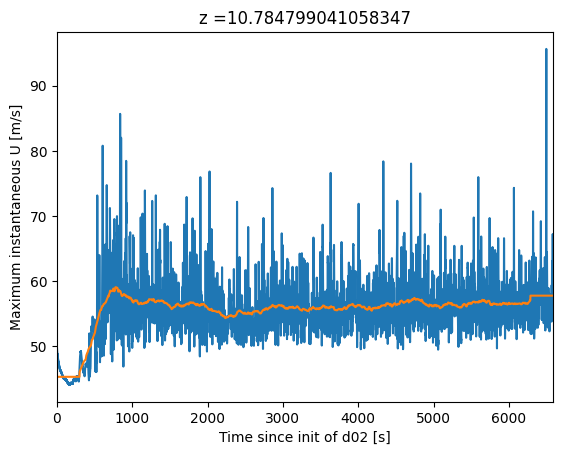

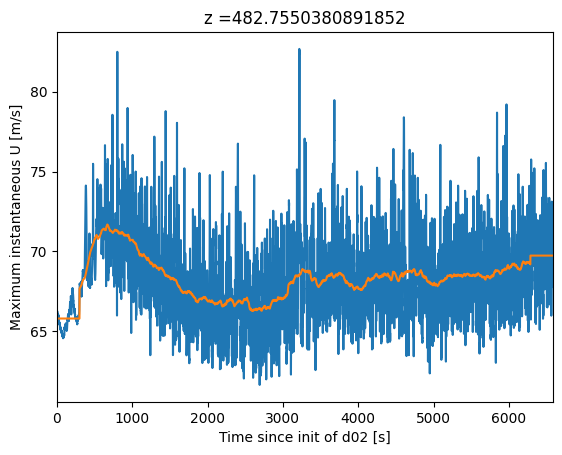

In [16]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
# Define moving average window for spin-up
window_spinUp = 5*60 # [s]
n_window_spinUp = int(window_spinUp/dt)

col = plt.cm.viridis(np.linspace(0,1,len(locs)))

# Surface
iz = 0
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,moving_average(np.nanmax(np.abs(UV[:,:,iz]),axis=0),n_window_spinUp,'same'))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()


# Boundary layer
iz = -1
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,moving_average(np.nanmax(np.abs(UV[:,:,iz]),axis=0),n_window_spinUp,'same'))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()

# Remove data before spinup

In [17]:
#%% Time required for spinup
t_spin_0 = 30*60
if 'sst_26' in WRF_DIRECTORY:
    t_spin_0 = 33*60
elif 'sst_30' in WRF_DIRECTORY:
    t_spin_0 = 34*60
    
print("%f minutes (%f seconds) for spinup" % (t_spin_0/60, t_spin_0))

30.000000 minutes (1800.000000 seconds) for spinup


In [18]:
# Remove times before spinup

UV = UV[:,time_sinceRst>t_spin_0,:]
wDir = wDir[:,time_sinceRst>t_spin_0,:]
r_fromC = r_fromC[time_sinceRst>t_spin_0,:]
time_sinceRst = time_sinceRst[time_sinceRst>t_spin_0]


## Get moving average from hurricane

In [19]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


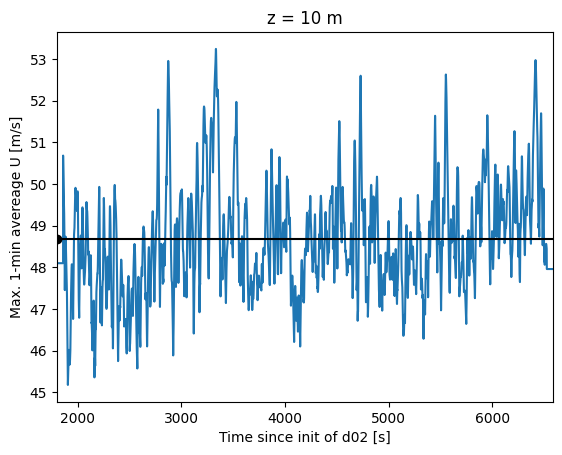

Category-2 Hurricane with 48.670000 m/s average max. 1-min sustained winds


In [20]:
#%% Hurricane intensity
window_1m = 1*60 # [s]
n_window_1m = int(window_1m/dt)

avgUV_1m = np.zeros(np.shape(UV))
avgUV_1m = avgUV_1m[:,:,0]

for i_s in np.arange(np.shape(UV)[0]):
    avgUV_1m[i_s,:] = moving_average(UV[i_s,:,0],n_window_1m,'same')
    
# Mean intensity
mean_intensity = np.mean(np.max(np.abs(avgUV_1m[:,time_sinceRst>t_spin_0]),axis=0))

    
plt.figure()
plt.title('z = '+str(int(hgt_agl[0]))+" m")
# plt.plot(time_sinceRst,np.max(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,np.max(np.abs(avgUV_1m),axis=0))
plt.plot([t_spin_0,time_sinceRst[-1]+1000],[mean_intensity,mean_intensity],'-o',color='black')
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Max. 1-min avereage U [m/s]')
plt.show()
plt.close()

# print(mean_intensity)

## Intensity of storm
thres_Cat1 = 33
thres_Cat2 = 43
thres_Cat3 = 50
thres_Cat4 = 58
thres_Cat5 = 70


if mean_intensity < thres_Cat1:
    print("Tropical Storm with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat1) & (mean_intensity < thres_Cat2):
    print("Category-1 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat2) & (mean_intensity < thres_Cat3):
    print("Category-2 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat3) & (mean_intensity < thres_Cat4):
    print("Category-3 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat4) & (mean_intensity < thres_Cat5):
    print("Category-4 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif mean_intensity>=thres_Cat5:
    print("Category-5 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))

In [21]:
time_sinceRst[0]

1800.1511999999639

In [22]:
#%% Turbine rotor layer
i_zzz_RL = np.where((hgt_agl>z_hh-0.55*D) & (hgt_agl<z_hh+0.6*D))[0]
i_zzz = np.where((hgt_agl>z_hh-1*D) & (hgt_agl<z_hh+0.6*D))[0]

print(hgt_agl[i_zzz])
print(hgt_agl[i_zzz_RL])

i_hh = i_zzz[0] + np.argmin(np.abs(hgt_agl[i_zzz] - z_hh)) + 1
print(hgt_agl[i_hh])

[ 10.78479904  32.88407982  56.06937438  80.39488141 105.91677186
 132.69394121 160.78858499]
[ 32.88407982  56.06937438  80.39488141 105.91677186 132.69394121
 160.78858499]
105.91677186199828


In [23]:
#%% Estimate 10-min horizontal wind speed statistics
window_10m = 10*60 # [s]
n_window_10m = int(window_10m/dt)

# Height of interest
zzz = z_hh
# i_zzz = np.argmin(np.abs(hgt_agl - zzz))

avgUV_10m = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in i_zzz: #np.arange(np.shape(UV)[2]): # height
        avgUV_10m[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window_10m,'same')

avgUV_10m_hh = avgUV_10m[:,:,i_hh]

print('Done estimating %f second statistics' % window_10m)

Done estimating 600.000000 second statistics


In [24]:
#%% Estimate perturbation quantities
pertUV = UV[:,:,i_hh] - avgUV_10m_hh

# pertUV[np.isnan(pertUV)] = 0.0

# Detrend perturbations
pertUV = scipy.signal.detrend(pertUV,axis=1)

# Variance oh horizontal velocity
var_UV_hh = pertUV*pertUV

print('Done estimating perturbation quantities')

Done estimating perturbation quantities


In [25]:
#%% Estimate 3-sec horizontal wind speed statistics
window_3s = 3 # [s]
n_window_3s = int(window_3s/dt)

avgUV_3s_hh = np.zeros(np.shape(UV)[0:2])

# Height of interest
zzz = z_hh
# i_zzz = np.argmin(np.abs(hgt_agl - zzz))

avgUV_3s = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in i_zzz: #np.arange(np.shape(UV)[2]): # height
        avgUV_3s[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window_3s,'same')
        
avgUV_3s_hh = avgUV_3s[:,:,i_hh]

print('Done estimating %f second statistics' % window_3s)

Done estimating 3.000000 second statistics


In [26]:
# Define eyewall radius based on 3D fields
if 'sst_26' in WRF_DIRECTORY:
    r_eye = 13805
    r_eye = 25000 #23361
    label = '26 C'
elif 'sst_27' in WRF_DIRECTORY:
    r_eye = 18481
    r_eye = 19138.9
    label = '27 C'
elif 'sst_28' in WRF_DIRECTORY:
    r_eye = 21300
    r_eye = 15138
    label = '28 C'
elif 'sst_30' in WRF_DIRECTORY:
    r_eye = 20333
    label = '30 C'
elif 'sst_32' in WRF_DIRECTORY:
    r_eye = 27055
    label = '32 C'
elif 'sst_34' in WRF_DIRECTORY:
    r_eye = 33638.915
    label = '34 C'

print('Eyewall radius at r = %f km' % (r_eye/1000))


Eyewall radius at r = 19.138900 km


In [27]:
# Radial locations of interest (changes over time)
# Radius of interest
r_r = np.arange(0.9,1.4,0.1)
# r_r = np.arange(0.8,1.3,0.1)
# r_r = np.arange(1.1,1.6,0.1)

# Indices for each timestep
i_rrr = np.zeros([len(time_sinceRst),np.shape(locs)[0]])  # [time,stat]

    
for i_s in np.arange(np.shape(locs)[0]):
    i_rrr[:,i_s] = (r_fromC[:,i_s]>r_r[0]*r_eye) & (r_fromC[:,i_s]<=r_r[-1]*r_eye)
i_rrr = i_rrr.astype('int')


# Get 3-sec and 10-min data for radius of interest 
temp_arr_3s = np.zeros_like(avgUV_3s) + np.nan
temp_arr_10m = np.zeros_like(avgUV_10m) + np.nan
for i_s in np.arange(np.shape(locs)[0]):
    temp_arr_3s[i_s,np.where(i_rrr[:,i_s])[0],:] = avgUV_3s[i_s,np.where(i_rrr[:,i_s])[0],:] + 0.0
    temp_arr_10m[i_s,np.where(i_rrr[:,i_s])[0],:] = avgUV_10m[i_s,np.where(i_rrr[:,i_s])[0],:] + 0.0
#     for i_t in np.arange(np.shape(avgUV_3s)[1]):
#         if i_rrr[i_t,i_s]==1:
#             temp_arr_3s[i_s,i_t,:] = avgUV_3s[i_s,i_t,:] + 0.0
#             temp_arr_10m[i_s,i_t,:] = avgUV_10m[i_s,i_t,:] + 0.0



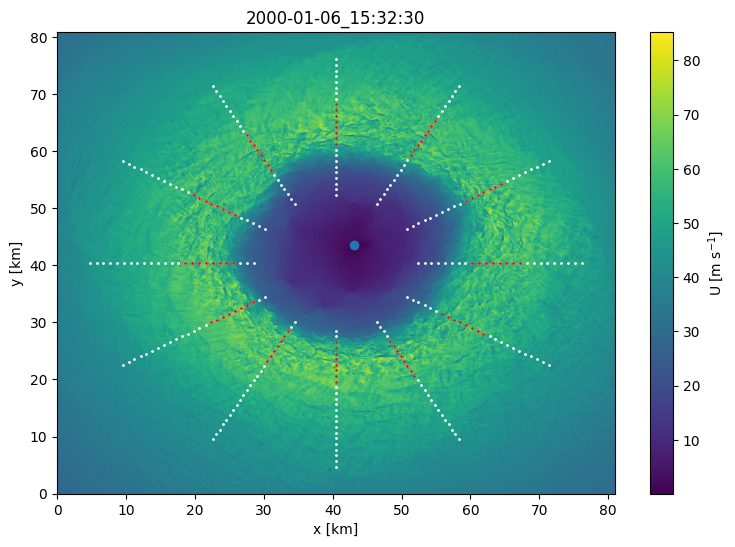

In [28]:
#%% Show met-tower locations within range

ittt = np.argmin(np.abs( time_sinceRst -  ((ttime_3d - startTime_dom)/np.timedelta64(1,'s'))))
ittt_cent = -1# np.argmin(np.abs( time_center_sinceRst - ((ttime_3d - startTime_dom)/np.timedelta64(1,'s'))))

iz = -1 #int(i_hh + 0)

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
if len(np.shape(center_x))>1:
    plt.scatter(center_x[ittt_cent,0]/1000,center_y[ittt_cent,0]/1000)
else:
    plt.scatter(center_x[ittt_cent]/1000,center_y[ittt_cent]/1000)
for i in np.arange(np.shape(locs)[0]):
    if (i_rrr[ittt,i]==1):
        plt.scatter(n_x[locs[i,0]]/1000,n_y[locs[i,1]]/1000,s=1,color='red')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


Done estimating fit of 3-sec wind profile to power-law wind profile
Done estimating fit of 10-min wind profile to power-law wind profile
 
Only using 3-s data 30.000000 min after restart
Mean 3-sec alpha is 0.135585
0.699876 fraction of cases display larger shear than design specifications
 
Only using 10-min data 30.000000 min after restart
Mean 10-min alpha is 0.134615
0.839908 fraction of cases display larger shear than design specifications


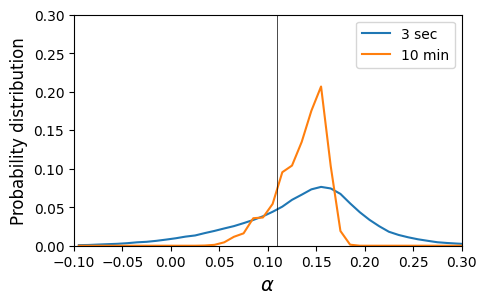

Wind shear is larger between r/R=[1,1.4] compared to r/R=[0.8,1.2]


In [29]:
# Fit hurricane profiles to power law
from scipy.optimize import curve_fit

def powLaw(z_z,alpha):
    u_o = u_curr;
    UUU = u_o*((z_z/z_hh)**alpha)
    return UUU

# Fit 3-sec propfiles
alpha_fit_3s = np.zeros(np.shape(temp_arr_3s)[0:2]) + np.nan
for i_s in np.arange(np.shape(alpha_fit_3s)[0]):
    for it in np.arange(0,np.shape(temp_arr_3s)[1],n_window_3s):
        u_curr = temp_arr_3s[i_s,it,i_hh]
        if np.sum(np.logical_not(np.isnan(temp_arr_3s[i_s,it,i_zzz_RL])))>0:
            popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], temp_arr_3s[i_s,it,i_zzz_RL])
            alpha_fit_3s[i_s,it] = popt[0]

print("Done estimating fit of 3-sec wind profile to power-law wind profile")

# Fit 10-min propfiles
alpha_fit_10m = np.zeros(np.shape(temp_arr_10m)[0:2]) + np.nan
for i_s in np.arange(np.shape(alpha_fit_10m)[0]):
    for it in np.arange(0,np.shape(temp_arr_10m)[1],n_window_3s):
        u_curr = temp_arr_10m[i_s,it,i_hh]
        if np.sum(np.logical_not(np.isnan(temp_arr_10m[i_s,it,i_zzz_RL])))>0:
            popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], temp_arr_10m[i_s,it,i_zzz_RL])
            alpha_fit_10m[i_s,it] = popt[0]

print("Done estimating fit of 10-min wind profile to power-law wind profile")

# Bins alpha
bins_alpha = np.arange(-0.1,0.55,0.01)

# Histograms
tttt = alpha_fit_3s.flatten() + 0.0
tttt = tttt[np.logical_not(np.isnan(tttt))]
print(" ")
print('Only using 3-s data %f min after restart' % (t_spin_0/60))
print("Mean 3-sec alpha is %f" % np.nanmean(tttt))
print("%f fraction of cases display larger shear than design specifications" % (np.sum(tttt>0.11)/np.sum(tttt>-100)))
# stop
hist_3s_alpha = np.histogram(tttt,bins=bins_alpha)
hist_3s_alpha = hist_3s_alpha[0]/np.nansum(hist_3s_alpha[0])

tttt = alpha_fit_10m.flatten() + 0.0
tttt = tttt[np.logical_not(np.isnan(tttt))]
print(" ")
print('Only using 10-min data %f min after restart' % (t_spin_0/60))
print("Mean 10-min alpha is %f" % np.nanmean(tttt))
print("%f fraction of cases display larger shear than design specifications" % (np.sum(tttt>0.11)/np.sum(tttt>-100)))
# stop
hist_10m_alpha = np.histogram(tttt,bins=bins_alpha)
hist_10m_alpha = hist_10m_alpha[0]/np.nansum(hist_10m_alpha[0])

bins_alpha = 0.5*(bins_alpha[1:] + bins_alpha[0:-1])

# Figure
plt.figure(figsize=(5,3))
plt.plot(bins_alpha,hist_3s_alpha,label='3 sec')
plt.plot(bins_alpha,hist_10m_alpha,label='10 min')
plt.plot([0.11,0.11],[0,1],'-k',linewidth=0.5)
plt.ylim(0,0.3)
plt.xlim(-0.1,0.3)
plt.xlabel(r"$\alpha$",fontsize=14)
plt.ylabel(r"Probability distribution",fontsize=12)
plt.legend()
plt.show()
plt.close()

#%% Distributions of alpha
saveAlpha_distr = 'False'
if saveAlpha_distr == 'True':
    fName = 'alpha_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_alpha)):
            strr = ''
            strr = str(bins_alpha[i])  + ',' + str(hist_3s_alpha[i]) + ',' + str(hist_10m_alpha[i])
            f.write(strr)
            f.write('\n')
            
            
# stop

print("Wind shear is larger between r/R=[1,1.4] compared to r/R=[0.8,1.2]")

In [30]:
#%% Define functions that estimate change in wind direction

# Define function that estimates temporal change in wind direction for one height
def delta_wDir_oneZ(wDir1,wDir2):
    delta = np.abs(wDir1 - wDir2)
    
    if delta>180:
        delta = 360 - delta
        
    return delta



# Define function that estimates vertical change in wind direction for one time
def delta_wDir_twoZ(wDir1,wDir2,z1,z2,normalize):
    wDir_low = wDir1
    wDir_high = wDir2
    
    delta = 0
    
    if np.abs(wDir_high-wDir_low)<=0:#180:
        delta = wDir_high-wDir_low
    else:
        a = np.abs(wDir_high-wDir_low)
        b = np.abs(360-a)
        delta = np.min([a,b])
        
        if (wDir_high>=0) & (wDir_high<=90):
            if (wDir_low>=270) & (wDir_low<=360):
                delta = 1*delta
        elif (wDir_high>=270) & (wDir_high<=360):
            if (wDir_low>=0) & (wDir_low<=90):
                delta = -1*delta
    
    dz = z2-z1
    if dz>0:
        if normalize=='True':
            delta = delta/dz
        
    return delta


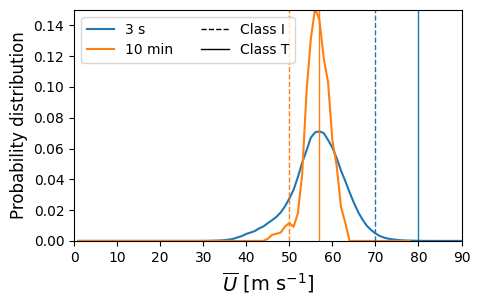

In [31]:
#%% One-dimensional histogram for 3-sec gust and 10-min wind speed
edges_gust = np.arange(1,100,1) #np.arange(np.min(avgUV_3s_hh),np.max(avgUV_3s_hh),1)
edges_mean = np.arange(1,80,1) #np.arange(np.min(avgUV_10m_hh),np.max(avgUV_10m_hh),1)

# Find locations and times when met-towers are within radius
UV_hh_3s_winds_within = np.array([])
UV_hh_10m_winds_within = np.array([])
for i_s in np.arange(np.shape(locs)[0]):
    UV_hh_3s_winds_within = np.append(UV_hh_3s_winds_within,avgUV_3s_hh[i_s,np.where(i_rrr[:,i_s])[0]])
    UV_hh_10m_winds_within = np.append(UV_hh_10m_winds_within,avgUV_10m_hh[i_s,np.where(i_rrr[:,i_s])[0]])

hist_gust_stats = np.histogram(UV_hh_3s_winds_within,bins=edges_gust)[0]
hist_mean_stats = np.histogram(UV_hh_10m_winds_within,bins=edges_mean)[0]

plt.figure(figsize=(5,3))
plt.plot(edges_gust[0:-1],hist_gust_stats/np.nansum(hist_gust_stats),label='3 s')
plt.plot(edges_mean[0:-1],hist_mean_stats/np.nansum(hist_mean_stats),label='10 min')
plt.plot([50,50],[0,1],linestyle='--',color='tab:orange',linewidth=1)
plt.plot([57,57],[0,1],linestyle='-',color='tab:orange',linewidth=1)
plt.plot([1.4*50,1.4*50],[0,1],linestyle='--',linewidth=1,color='tab:blue')
plt.plot([1.4*57,1.4*57],[0,1],linestyle='-',linewidth=1,color='tab:blue')
plt.plot([1.4*50,1.4*50],[0,-1],linestyle='--',linewidth=1,color='black',label='Class I')
plt.plot([1.4*57,1.4*57],[0,-1],linestyle='-',linewidth=1,color='black',label='Class T')
plt.ylim(0,0.15)
plt.xlim(0,90)
plt.xlabel(r"$\overline{U}$ [m s$^{-1}$]",fontsize=14)
plt.ylabel(r"Probability distribution",fontsize=12)
plt.legend(ncol=2,loc=2)
plt.show()
plt.close()

save_oneDimProb = 'False';
if save_oneDimProb=='True':
    import pickle
    fName_Prob_mean = 'prob_mean.pkl'
    fName_Prob_gust = 'prob_gust.pkl'
    fName_edges_gust = 'edges_gust2.pkl'
    fName_edges_mean = 'edges_mean2.pkl'
    with open(WRF_DIRECTORY + fName_Prob_mean, 'wb') as file:
        pickle.dump(hist_mean_stats, file)
    with open(WRF_DIRECTORY + fName_Prob_gust, 'wb') as file:
        pickle.dump(hist_gust_stats, file)
    with open(WRF_DIRECTORY + fName_edges_gust, 'wb') as file:
        pickle.dump(edges_gust, file)
    with open(WRF_DIRECTORY + fName_edges_mean, 'wb') as file:
        pickle.dump(edges_mean, file)


In [32]:
#%% Choose radial increments for radial distributions
dr_incr = 1000

# Radial locations for all met-towers
r_flat = r_fromC.flatten()
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]

# Radial increments
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),dr_incr)


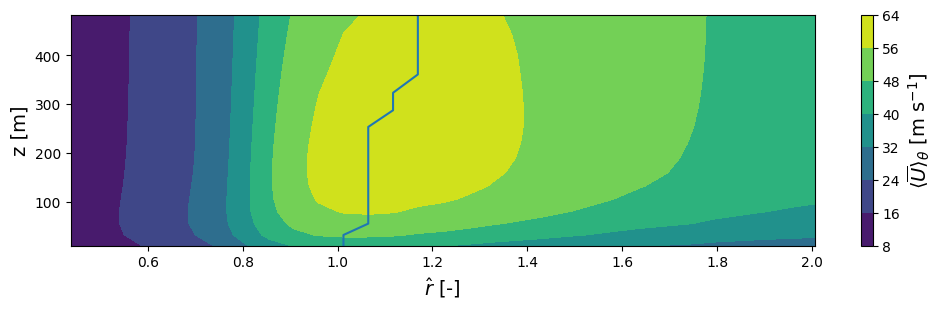

In [33]:
#%% Azimuthally averaged fields

r_t0 = radial_dist[0,:]

# Get time- and azimuthal-mean profiles at differnt radial locations
azim_mean_inst_U_prof = np.zeros([len(r_incr)-1,len(hgt_agl)])
for i_r in np.arange(len(r_incr)-1):
    i_r_within = (r_t0>r_incr[i_r]) & (r_t0<=r_incr[i_r+1])
    # Instantaneous
    azim_mean_inst_U_prof[i_r,:] = np.mean(UV[i_r_within,:,:],axis=(0,1))
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])



# Find radial distance for maximum in wind profile at each height
R_for_maxUV_atZ = np.zeros(len(hgt_agl))
for iz in np.arange(len(hgt_agl)):
    R_for_maxUV_atZ[iz] = r_incr_[np.argmax(azim_mean_inst_U_prof[:,iz])]

# Visualize fields
fig,axs = plt.subplots(1,1,figsize=(12,3))
im1 = axs.contourf(r_incr_/r_eye,hgt_agl,np.transpose(azim_mean_inst_U_prof))
axs.plot(R_for_maxUV_atZ/r_eye,hgt_agl)
cbar1 = fig.colorbar(im1,ax=axs)
cbar1.set_label(r"$\langle \overline{U} \rangle_{\theta}$ [m s$^{-1}$]",fontsize=14)
axs.set_xlabel(r'$\hat{r}$ [-]',fontsize=14)
axs.set_ylabel(r'z [m]',fontsize=14)

plt.show()
plt.close()



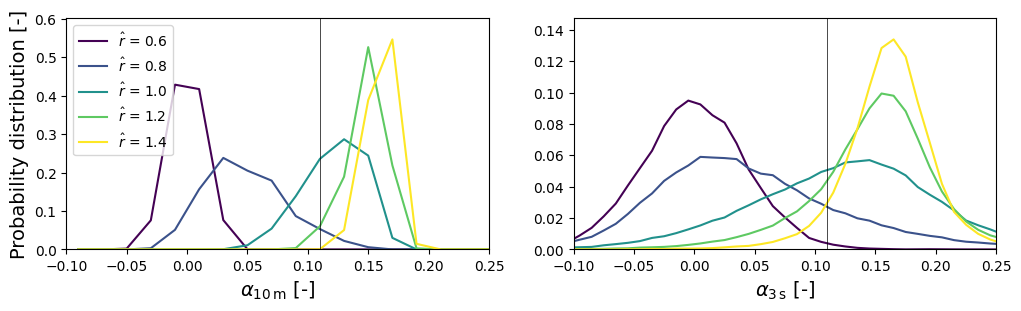

In [34]:
#%% Calculate alpha at each radial interval and get radial distribution of alpha

r_incr_alpha = np.arange(0.5,1.5+0.2,0.2)*r_eye
r_t0 = radial_dist[0,:]
bins_alpha_10m = np.arange(-0.1,0.55,0.02)
bins_alpha_3s = np.arange(-0.15,0.55,0.01)


# Get time- and azimuthal-mean profiles at differnt radial locations
azim_alpha_3s = np.zeros([len(r_incr_alpha)-1,len(bins_alpha_3s)-1]) # [r_incr, bins_alpha]
azim_alpha_10m = np.zeros([len(r_incr_alpha)-1,len(bins_alpha_10m)-1]) # [r_incr, bins_alpha]
for i_r in np.arange(len(r_incr_alpha)-1):
    i_r_within = (r_t0>r_incr_alpha[i_r]) & (r_t0<=r_incr_alpha[i_r+1])
    # Fit 3-s and 10-min profiles to power-law
    if np.sum(i_r_within)>0:
        wheres = np.where(i_r_within)[0]
        for i_stat in np.arange(len(wheres)):
            temp_alpha_3s = np.zeros(np.shape(avgUV_3s)[1]) + np.nan
            temp_alpha_10m = np.zeros(np.shape(avgUV_10m)[1]) + np.nan
            for it in np.arange(0,np.shape(avgUV_3s)[1],n_window_3s):
                # 3-second
                u_curr = avgUV_3s[wheres[i_stat],it,i_hh]
                popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], avgUV_3s[wheres[i_stat],it,i_zzz_RL])
                temp_alpha_3s[it] = popt[0]
                # 10-min
                u_curr = avgUV_10m[wheres[i_stat],it,i_hh]
                popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], avgUV_10m[wheres[i_stat],it,i_zzz_RL])
                temp_alpha_10m[it] = popt[0]
            # Remove NaNs
            temp_alpha_3s = temp_alpha_3s[np.logical_not(np.isnan(temp_alpha_3s))]
            temp_alpha_10m = temp_alpha_10m[np.logical_not(np.isnan(temp_alpha_10m))]
            # Save data
            temp_hist = np.histogram(temp_alpha_3s,bins=bins_alpha_3s)[0]
            azim_alpha_3s[i_r,:] = azim_alpha_3s[i_r,:] + temp_hist
            temp_hist = np.histogram(temp_alpha_10m,bins=bins_alpha_10m)[0]
            azim_alpha_10m[i_r,:] = azim_alpha_10m[i_r,:] + temp_hist

# Normalize distributions
for ir in np.arange(len(r_incr_alpha)-1):
    azim_alpha_10m[ir,:] = azim_alpha_10m[ir,:]/np.nansum(azim_alpha_10m[ir,:])
    azim_alpha_3s[ir,:] = azim_alpha_3s[ir,:]/np.nansum(azim_alpha_3s[ir,:])

# Center point of radial distances and alpha bins
bins_alpha_plot_3s = 0.5*(bins_alpha_3s[1:] + bins_alpha_3s[0:-1])
bins_alpha_plot_10m = 0.5*(bins_alpha_10m[1:] + bins_alpha_10m[0:-1])
r_incr_alpha_plot = 0.5*(r_incr_alpha[1:] + r_incr_alpha[0:-1])

# Figure showing alpha distribution at different radial locations
cols = plt.cm.viridis(np.linspace(0,1,np.shape(azim_alpha_3s)[0]))
plt.figure(figsize=(12,3))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
for ir in np.arange(len(r_incr_alpha_plot)):
    ax0.plot(bins_alpha_plot_10m,azim_alpha_10m[ir,:],color=cols[ir],label=r'$\hat{r}$ = '+str(np.round(r_incr_alpha_plot[ir]/r_eye,2)))
    ax1.plot(bins_alpha_plot_3s,azim_alpha_3s[ir,:],color=cols[ir])
ax0.plot([0.11,0.11],[0,1],'-k',linewidth=0.5)
ax1.plot([0.11,0.11],[0,1],'-k',linewidth=0.5)
ax0.set_xlim(-0.1,0.25)
ax1.set_xlim(-0.1,0.25)
ax0.set_ylim(0,1.1*np.nanmax(azim_alpha_10m))
ax1.set_ylim(0,1.1*np.nanmax(azim_alpha_3s))
ax0.set_ylabel('Probability distribution [-]',fontsize=14)
ax0.set_xlabel(r'$\alpha_{10\,\mathrm{m}}$ [-]',fontsize=14)
ax1.set_xlabel(r'$\alpha_{3\,\mathrm{s}}$ [-]',fontsize=14)
ax0.legend()
plt.show()
plt.close()



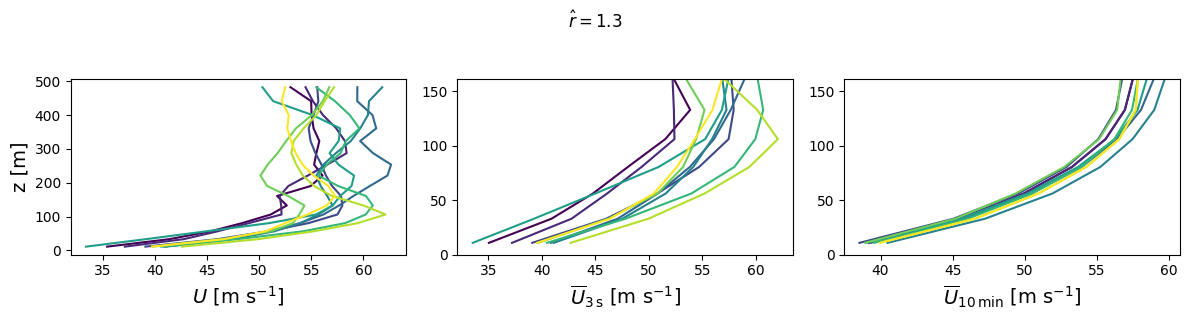

In [35]:
#%% Visualize temporal evolution of wind profile at one station

rad_dist = 1.3*r_eye

i_stst = np.argmin(np.abs(radial_dist[0,:]-rad_dist))

i_times = np.linspace(0,len(time_sinceRst)-1,10)
i_times = i_times.astype('int')
col = plt.cm.viridis(np.linspace(0,1,len(i_times)))

plt.figure(figsize=(12,3))
plt.suptitle(r"$\hat{r} = $" + str(np.round(rad_dist/r_eye,2)),y=1.05)
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for it in np.arange(len(i_times)):
    # Instantaneous
    ax1.plot(UV[i_stst,i_times[it],:],hgt_agl,color=col[it])
    # 3-second average
    tmp = avgUV_3s[i_stst,i_times[it],:] + 0.0
    tmp[tmp==0] = np.nan
    ax2.plot(tmp,hgt_agl,color=col[it])
    # 3-second average
    tmp = avgUV_10m[i_stst,i_times[it],:] + 0.0
    tmp[tmp==0] = np.nan
    ax3.plot(tmp,hgt_agl,color=col[it])
# ax1.set_ylim(0,np.max(hgt_agl[tmp>0]))
ax2.set_ylim(0,np.max(hgt_agl[tmp>0]))
ax3.set_ylim(0,np.max(hgt_agl[tmp>0]))
ax1.set_ylabel("z [m]",fontsize=14)
ax1.set_xlabel("$U$ [m s$^{-1}$]",fontsize=14)
ax2.set_xlabel("$\overline{U}_{3\, \mathrm{s}}$ [m s$^{-1}$]",fontsize=14)
ax3.set_xlabel("$\overline{U}_{10\, \mathrm{min}}$ [m s$^{-1}$]",fontsize=14)

plt.tight_layout()
plt.show()
plt.close()

In [36]:
hgt_agl[i_zzz_RL]

array([ 32.88407982,  56.06937438,  80.39488141, 105.91677186,
       132.69394121, 160.78858499])

In [ ]:
STOP

In [ ]:
# Radial locations of interest
r_r = np.arange(0.9,1.3,0.1)
r_t0 = radial_dist[0,:]
i_rrr = (r_t0>r_r[0]*r_eye) & (r_t0<=r_r[-1]*r_eye)

# Fit hurricane profiles to power law
from scipy.optimize import curve_fit

def powLaw(z_z,alpha):
    u_o = u_curr;
    UUU = u_o*((z_z/z_hh)**alpha)
    return UUU



# Fit 3-sec propfiles
iz_max = np.argmin(np.abs(hgt_agl - (z_hh + 0.6*D)))
temp_arr_3s = avgUV_3s[i_rrr,:,:]
alpha_fit_3s = np.zeros(np.shape(temp_arr_3s)[0:2]) + np.nan
for i_s in np.arange(np.shape(alpha_fit_3s)[0]):
    for it in np.arange(0,np.shape(temp_arr_3s)[1],n_window_3s):
        u_curr = temp_arr_3s[i_s,it,i_hh]
#         popt, pcov = curve_fit(powLaw, hgt_agl[0:iz_max], temp_arr_3s[i_s,it,0:iz_max])
        popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], temp_arr_3s[i_s,it,i_zzz_RL])
        alpha_fit_3s[i_s,it] = popt[0]

print("Done estimating fit of 3-sec wind profile to power-law wind profile")

# Fit 10-min propfiles
temp_arr_10m = avgUV_10m[i_rrr,:,:]
alpha_fit_10m = np.zeros(np.shape(temp_arr_10m)[0:2]) + np.nan
for i_s in np.arange(np.shape(alpha_fit_10m)[0]):
    for it in np.arange(0,np.shape(temp_arr_10m)[1],n_window_3s):
        u_curr = temp_arr_10m[i_s,it,i_hh]
#         popt, pcov = curve_fit(powLaw, hgt_agl[0:iz_max], temp_arr_10m[i_s,it,0:iz_max])
        popt, pcov = curve_fit(powLaw, hgt_agl[i_zzz_RL], temp_arr_10m[i_s,it,i_zzz_RL])
        alpha_fit_10m[i_s,it] = popt[0]

print("Done estimating fit of 10-min wind profile to power-law wind profile")

# Bins alpha
bins_alpha = np.arange(-0.1,0.55,0.01)

# Histograms
tttt = alpha_fit_3s + 0.0
tttt = tttt[:,time_sinceRst>t_spin_0]
print(" ")
print('Only using 3-s data %f min after restart' % (t_spin_0/60))
print("Mean 3-sec alpha is %f" % np.nanmean(tttt))
print("%f fraction of cases display larger shear than design specifications" % (np.sum(tttt>0.11)/np.sum(tttt>-100)))
# stop
hist_3s_alpha = np.histogram(np.reshape(tttt,np.prod(np.shape(tttt))),bins=bins_alpha)
hist_3s_alpha = hist_3s_alpha[0]/np.nansum(hist_3s_alpha[0])

tttt = alpha_fit_10m + 0.0
tttt = tttt[:,time_sinceRst>t_spin_0]
print(" ")
print('Only using 10-min data %f min after restart' % (t_spin_0/60))
print("Mean 10-min alpha is %f" % np.nanmean(tttt))
print("%f fraction of cases display larger shear than design specifications" % (np.sum(tttt>0.11)/np.sum(tttt>-100)))
# stop
hist_10m_alpha = np.histogram(np.reshape(tttt,np.prod(np.shape(tttt))),bins=bins_alpha)
hist_10m_alpha = hist_10m_alpha[0]/np.nansum(hist_10m_alpha[0])

bins_alpha = 0.5*(bins_alpha[1:] + bins_alpha[0:-1])

# Figure
plt.figure()
plt.plot(bins_alpha,hist_3s_alpha,label='3 sec')
plt.plot(bins_alpha,hist_10m_alpha,label='10 min')
plt.plot([0.11,0.11],[0,1],'-k',linewidth=0.5)
plt.ylim(0,0.3)
plt.xlim(-0.1,0.3)
plt.xlabel(r"$\alpha$",fontsize=14)
plt.ylabel(r"Probability distribution",fontsize=12)
plt.legend()
plt.show()
plt.close()

#%% Distributions of alpha
saveAlpha_distr = 'False'
if saveAlpha_distr == 'True':
    fName = 'alpha_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_alpha)):
            strr = ''
            strr = str(bins_alpha[i])  + ',' + str(hist_3s_alpha[i]) + ',' + str(hist_10m_alpha[i])
            f.write(strr)
            f.write('\n')
            
            
# stop

print("Wind shear is larger between r/R=[1,1.4] compared to r/R=[0.8,1.2]")

In [ ]:
np.shape(locs)

In [ ]:
np.shape(radial_dist)

In [ ]:
#%% Show met-tower locations within range

iz = 7

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
for i in np.arange(np.shape(locs)[0]):
    if (radial_dist[0,i]>=r_r[0]*r_eye) & (radial_dist[0,i]<=r_r[-1]*r_eye):
        plt.scatter(n_x[locs[i,0]]/1000,n_y[locs[i,1]]/1000,s=1,color='red')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


In [ ]:
#%% Define functions that estimate change in wind direction

# Define function that estimates temporal change in wind direction for one height
def delta_wDir_oneZ(wDir1,wDir2):
    delta = np.abs(wDir1 - wDir2)
    
    if delta>180:
        delta = 360 - delta
        
    return delta



# Define function that estimates vertical change in wind direction for one time
def delta_wDir_twoZ(wDir1,wDir2,z1,z2,normalize):
    wDir_low = wDir1
    wDir_high = wDir2
    
    delta = 0
    
    if np.abs(wDir_high-wDir_low)<=0:#180:
        delta = wDir_high-wDir_low
    else:
        a = np.abs(wDir_high-wDir_low)
        b = np.abs(360-a)
        delta = np.min([a,b])
        
        if (wDir_high>=0) & (wDir_high<=90):
            if (wDir_low>=270) & (wDir_low<=360):
                delta = 1*delta
        elif (wDir_high>=270) & (wDir_high<=360):
            if (wDir_low>=0) & (wDir_low<=90):
                delta = -1*delta
    
    dz = z2-z1
    if dz>0:
        if normalize=='True':
            delta = delta/dz
        
    return delta


In [ ]:
# #%% Estimate 6-sec yaw misalignment
# window_6s = 10 # [s]
# n_window_6s = int(window_6s/dt)

# # Height of interest
# zzz = z_hh
# i_zzz = np.argmin(np.abs(hgt_agl - zzz))

# # Temporal change in wind direction over time window    
# yaw_mis = np.zeros(np.shape(wDir)[0:2]) + np.nan
# for i_s in np.arange(np.shape(locs)[0]):
#     for i_t in np.arange(np.shape(wDir)[1]-n_window_6s):
#         # Yaw-misalignment
#         tempMax = 0
#         mxx = np.max(wDir[i_s,i_t:i_t+n_window_6s,i_zzz])
#         mnn = np.min(wDir[i_s,i_t:i_t+n_window_6s,i_zzz])
#         tempMax = delta_wDir_oneZ(mxx,mnn)
#         yaw_mis[i_s,i_t] = tempMax
#     # print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

# print('Done estimating yaw-misalignment for %f second statistics' % window_6s)

In [ ]:
# #%% Estimate 10-sec coherent gust (wind speed and wind direction)
# window_10s = 10 # [s]
# n_window_10s = int(window_10s/dt)

# # Height of interest
# zzz = z_hh
# i_zzz = np.argmin(np.abs(hgt_agl - zzz))

# # Temporal change in wind direction over time window    
# coh_gust = np.zeros(np.concatenate([np.shape(wDir)[0:2],[2]])) + np.nan # [loc,time,speed/dir]
# for i_s in np.arange(np.shape(locs)[0]):
#     # Wind speed
# #     coh_gust[i_s,:,0] = moving_average(UV[i_s,:,i_zzz],window_10s,'same')
#     for i_t in np.arange(np.shape(wDir)[1]-n_window_10s):
#         # Yaw-misalingment
#         tempMax_YM = 0
#         mxx = np.max(wDir[i_s,i_t:i_t+n_window_10s,i_zzz])
#         mnn = np.min(wDir[i_s,i_t:i_t+n_window_10s,i_zzz])
#         tempMax_YM = delta_wDir_oneZ(mxx,mnn)
#         coh_gust[i_s,i_t,1] = tempMax_YM
#         # Wind speed gust
#         tempMax_g = 0
#         mxx = np.max(UV[i_s,i_t:i_t+n_window_10s,i_zzz])
#         mnn = np.min(UV[i_s,i_t:i_t+n_window_10s,i_zzz])
#         tempMax_g = np.abs(mxx - mnn)
#         coh_gust[i_s,i_t,0] = tempMax_g
        
#     # print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

# print('Done estimating coherent gusts for %f second intervals' % window_10s)

In [ ]:
# #%% Estimate wind speed shear over turbine rotor layer using 10-min wind speed
# z_bott = z_hh - 0.5*D
# z_top = z_hh + 0.5*D
# iz_b = np.argmin(np.abs(hgt_agl - z_bott))
# iz_t = np.argmin(np.abs(hgt_agl - z_top))

# sp_shear = np.zeros(np.shape(wDir)[0:2]) + np.nan
# for i_s in np.arange(np.shape(locs)[0]):
#     uv_top = moving_average(UV[i_s,:,iz_t],n_window_6s,'same')
#     uv_bot = moving_average(UV[i_s,:,iz_b],n_window_6s,'same')
#     sp_shear[i_s,:] = (uv_top - uv_bot)/(hgt_agl[iz_t] - hgt_agl[iz_b])

# print('Done estimating shear using 6-sec wind speed')

In [ ]:
# #%% Estiamte hurricane eyewall as maximum wind speed
# label = ''

# # Define eyewall radius based on 3D fields
# if 'sst_26' in WRF_DIRECTORY:
#     r_eye = 13805
#     r_eye = 21400
#     label = '26 C'
# elif 'sst_28' in WRF_DIRECTORY:
#     r_eye = 21300
#     label = '28 C'
# elif 'sst_30' in WRF_DIRECTORY:
#     r_eye = 20333
#     label = '30 C'
# elif 'sst_32' in WRF_DIRECTORY:
#     r_eye = 27055
#     label = '32 C'
# elif 'sst_34' in WRF_DIRECTORY:
#     r_eye = 33638.915
#     label = '34 C'

# print('Eyewall radius at r = %f km' % (r_eye/1000))


## Calculate hurricane statistics to THEN compare with IEC models

In [ ]:
np.shape(avgUV_10m_hh)

In [ ]:
#%% Find radial distribution of 10-min hub-height wind speed
## Prepare arrays
# Get radial distribution of 10-min wind speed gust at hub height
avgUV_10m_hh_flat  = np.transpose(avgUV_10m_hh).flatten()
# Sort arrays
avgUV_10m_hh_flat = avgUV_10m_hh_flat[i_sort]

## Get average 10-min gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_uv_10_r = np.zeros(len(r_incr)-1)
ith_perc_uv_10_r = np.zeros(len(r_incr)-1)
iith_perc_uv_10_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = avgUV_10m_hh_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    mean_uv_10_r[i_r] = np.mean(temp_arr)
    ith_perc_uv_10_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_uv_10_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

plt.figure()
# plt.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_10m_hh_flat[::int(10/ss)+1],label='10-min')
plt.plot(r_incr_/r_eye,mean_uv_10_r,label='Mean')
plt.fill(np.concatenate([r_incr_/r_eye,np.flip(r_incr_/r_eye)]),
            np.concatenate([ith_perc_uv_10_r,np.flip(iith_perc_uv_10_r)]),alpha=0.2)
# plt.plot(r_incr_/r_eye,ith_perc_uv_10_r,label=str(np.round(i_th*100,2))+'th percentile')
# plt.plot(r_incr_/r_eye,iith_perc_uv_10_r,label=str(np.round(ii_th*100,2))+'th percentile')
plt.xlabel(r'$\hat{r}$ [-]')
plt.ylabel('10-min HH Wind speed [m/s]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
plt.xlim(0.3,1.4)
plt.legend()
plt.show()

In [ ]:
np.sum(avgUV_10m_hh_flat>57)/len(avgUV_10m_hh_flat)

In [ ]:
#%% Find radial distribution of 3-sec hub-height wind speed
## Prepare arrays
# Get radial distribution of 3-sec wind speed gust at hub height
avgUV_3s_hh_flat  = np.transpose(avgUV_3s_hh).flatten()
# Sort arrays
avgUV_3s_hh_flat = avgUV_3s_hh_flat[i_sort]

## Get average 3-sec gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_uv_3s_r = np.zeros(len(r_incr)-1)
ith_perc_uv_3s_r = np.zeros(len(r_incr)-1)
iith_perc_uv_3s_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = avgUV_3s_hh_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    mean_uv_3s_r[i_r] = np.mean(temp_arr)
    ith_perc_uv_3s_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_uv_3s_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

plt.figure()
# plt.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_3s_hh_flat[::int(10/ss)+1],label='3-sec gust')
plt.plot(r_incr_/r_eye,mean_uv_3s_r,label='Mean')
plt.fill(np.concatenate([r_incr_/r_eye,np.flip(r_incr_/r_eye)]),
            np.concatenate([ith_perc_uv_3s_r,np.flip(iith_perc_uv_3s_r)]),alpha=0.2)
# plt.plot(r_incr_/r_eye,ith_perc_uv_3s_r,label=str(np.round(i_th*100,2))+'th percentile')
# plt.plot(r_incr_/r_eye,iith_perc_uv_3s_r,label=str(np.round(ii_th*100,2))+'th percentile')
plt.xlabel(r'$\hat{r}$ [-]')
plt.ylabel('3-sec HH Wind speed [m/s]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
plt.xlim(0.3,1.4)
plt.legend()
plt.show()

In [ ]:
np.sum(avgUV_3s_hh_flat>0.8*1.4*57)/len(avgUV_3s_hh_flat)

In [ ]:
# #%% Find radial distribution of 6-sec yaw-misalignment
# ## Prepare arrays
# yaw_mis_flat  = np.transpose(yaw_mis).flatten()
# # Sort arrays
# yaw_mis_flat = yaw_mis_flat[i_sort]

# ## Get average 6-sec gust on dr_incr radial increments and i-th percentile
# alpha_CI = 0.05
# i_th = 1-(0.5*alpha_CI)
# ii_th = 0.5*alpha_CI
# mean_yawMis_6s_r = np.zeros(len(r_incr)-1)
# ith_perc_yawMis_6s_r = np.zeros(len(r_incr)-1)
# iith_perc_yawMis_6s_r = np.zeros(len(r_incr)-1)
# for i_r in np.arange(len(r_incr)-1):
#     temp_arr = yaw_mis_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
#     temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
#     mean_yawMis_6s_r[i_r] = np.nanmean(temp_arr)
#     ith_perc_yawMis_6s_r[i_r] = np.percentile(temp_arr,i_th*100)
#     iith_perc_yawMis_6s_r[i_r] = np.percentile(temp_arr,ii_th*100)
# r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

# plt.figure()
# plt.plot(r_sort[::int(10/ss)+1]/r_eye,yaw_mis_flat[::int(10/ss)+1],label='6-sec gust')
# plt.plot(r_incr_/r_eye,mean_yawMis_6s_r,label='Mean')
# plt.plot(r_incr_/r_eye,ith_perc_yawMis_6s_r,label=str(np.round(i_th*100,2))+'th percentile')
# plt.plot(r_incr_/r_eye,iith_perc_yawMis_6s_r,label=str(np.round(ii_th*100,2))+'th percentile')
# plt.xlabel('r [km]')
# plt.ylabel('6-sec Yaw misalingment [deg]')
# plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
# plt.ylim(0,np.nanmax(yaw_mis_flat))
# plt.legend()
# plt.show()


# # Distribution of max yaw misalignment at multiple radial locations
# yaw_incr = np.arange(0,40,0.5)
# distr_yawMis_r = np.zeros([len(r_incr)-1,len(yaw_incr)-1])
# for ir in np.arange(len(r_incr)-1):
#     temp_arr = yaw_mis_flat[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
#     temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
#     distr_yawMis_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=yaw_incr)[0]
# bins_plot = 0.5*(yaw_incr[1:] + yaw_incr[0:-1])


# #%% Save yaw misalignment distributions
# saveYawMis_distr = 'False'
# if saveYawMis_distr == 'True':
#     norm_distr_yawMis_r = np.zeros_like(distr_yawMis_r) + distr_yawMis_r
#     for ii in np.arange(len(distr_yawMis_r[:,0])):
#         norm_distr_yawMis_r[ii,:] = norm_distr_yawMis_r[ii,:]/np.sum(norm_distr_yawMis_r[ii,:])
#     fName = 'yawMis_distr.txt'
#     with open(WRF_DIRECTORY + fName, 'w') as f:
#         for i in np.arange(len(bins_plot)+1):
#             strr = ''
#             if i==0:
#                 for ir in np.arange(len(r_incr)-1):
#                     rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
#                     if ir == 0:
#                         strr = strr + str(rrr)
#                     else:
#                         strr = strr + ',' + str(rrr)
#             else:
#                 strr = strr + str(bins_plot[i-1]) 
#                 for rr in np.arange(len(distr_yawMis_r[:,0])):
#                     strr = strr + ',' + str(norm_distr_yawMis_r[rr,i-1]) # yawMis,pdf_r_i
#             f.write(strr)
#             f.write('\n')
            
# stop

In [ ]:
#%% Distribution of standard deviation at multiple radial locations
# Get radial distribution of 3-sec wind speed gust at hub height
var_UV_hh_flat  = np.transpose(var_UV_hh).flatten()
# Sort arrays
var_UV_hh_flat = var_UV_hh_flat[i_sort]
std_UV_hh_flat = var_UV_hh_flat**0.5


std_incr = np.arange(0,40,0.5)
distr_std_r = np.zeros([len(r_incr)-1,len(std_incr)-1])
for ir in np.arange(len(r_incr)-1):
    temp_arr = std_UV_hh_flat[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    distr_std_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=std_incr)[0]
bins_plot = 0.5*(std_incr[1:] + std_incr[0:-1])

#%% Save yaw misalignment distributions
saveStd_distr = 'False'
if saveStd_distr == 'True':
    norm_distr_std_r = np.zeros_like(distr_std_r) + distr_std_r
    for ii in np.arange(len(distr_std_r[:,0])):
        norm_distr_std_r[ii,:] = norm_distr_std_r[ii,:]/np.sum(norm_distr_std_r[ii,:])
    fName = 'std_distr.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(bins_plot)+1):
            strr = ''
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                strr = strr + str(bins_plot[i-1]) 
                for rr in np.arange(len(distr_std_r[:,0])):
                    strr = strr + ',' + str(norm_distr_std_r[rr,i-1]) # yawMis,pdf_r_i
            f.write(strr)
            f.write('\n')
            

In [ ]:
#%% One-dimensional histogram for 3-sec gust and 10-min wind speed
edges_gust = np.arange(1,100,1) #np.arange(np.min(avgUV_3s_hh),np.max(avgUV_3s_hh),1)
edges_mean = np.arange(1,80,1) #np.arange(np.min(avgUV_10m_hh),np.max(avgUV_10m_hh),1)

hist_gust_stats = np.zeros([np.shape(locs)[0],len(edges_gust)-1]) + np.nan
hist_mean_stats = np.zeros([np.shape(locs)[0],len(edges_mean)-1]) + np.nan

for i_s in np.arange(np.shape(locs)[0]):
    hist_gust_stats[i_s,:] = np.histogram(avgUV_3s_hh[i_s,:],bins=edges_gust)[0]
    hist_mean_stats[i_s,:] = np.histogram(avgUV_10m_hh[i_s,:],bins=edges_mean)[0]
    
# r0 = r_r[0]*r_eye #0.85*23361  # 0.85*23361
# r1 = r_r[-1]*r_eye #1.25*23361  # 1.25*23361
i_rrr = (r_t0>r_r[0]*r_eye) & (r_t0<=r_r[-1]*r_eye)
# stat0 = np.argmin(np.abs(radial_dist[0,:] - r0)) # 33000
# stat1 = np.argmin(np.abs(radial_dist[0,:] - r1)) # 33000
# statss = np.array([stat0,stat1])
# statss = np.sort(statss)
print("r = [" + str(r_r[0]*r_eye/1000)+' km , '+str(r_r[-1]*r_eye/1000) + " km]")
# print(radial_dist[0,stat0])
# print(radial_dist[0,stat1])

hist_gust_stats = np.nansum(hist_gust_stats[i_rrr,:],axis=0)
hist_mean_stats = np.nansum(hist_mean_stats[i_rrr,:],axis=0)

plt.figure()
plt.plot(edges_gust[0:-1],hist_gust_stats/np.nansum(hist_gust_stats),label='3 s')
plt.plot(edges_mean[0:-1],hist_mean_stats/np.nansum(hist_mean_stats),label='10 min')
plt.plot([50,50],[0,1],linestyle='--',color='tab:orange',linewidth=1)
plt.plot([57,57],[0,1],linestyle='-',color='tab:orange',linewidth=1)
plt.plot([1.4*50,1.4*50],[0,1],linestyle='--',linewidth=1,color='tab:blue')
plt.plot([1.4*57,1.4*57],[0,1],linestyle='-',linewidth=1,color='tab:blue')
plt.plot([1.4*50,1.4*50],[0,-1],linestyle='--',linewidth=1,color='black',label='Class I')
plt.plot([1.4*57,1.4*57],[0,-1],linestyle='-',linewidth=1,color='black',label='Class T')
plt.ylim(0,0.25)
plt.xlim(0,90)
plt.xlabel(r"$\overline{U}$ [m s$^{-1}$]",fontsize=14)
plt.ylabel(r"Probability distribution",fontsize=12)
plt.legend(ncol=2,loc=1)
plt.show()
plt.close()

save_oneDimProb = 'False';
if save_oneDimProb=='True':
    import pickle
    fName_Prob_mean = 'prob_mean.pkl'
    fName_Prob_gust = 'prob_gust.pkl'
    fName_edges_gust = 'edges_gust2.pkl'
    fName_edges_mean = 'edges_mean2.pkl'
    with open(WRF_DIRECTORY + fName_Prob_mean, 'wb') as file:
        pickle.dump(hist_mean_stats, file)
    with open(WRF_DIRECTORY + fName_Prob_gust, 'wb') as file:
        pickle.dump(hist_gust_stats, file)
    with open(WRF_DIRECTORY + fName_edges_gust, 'wb') as file:
        pickle.dump(edges_gust, file)
    with open(WRF_DIRECTORY + fName_edges_mean, 'wb') as file:
        pickle.dump(edges_mean, file)


In [ ]:
STOP

In [ ]:
#%% Bi-dimensional histogram for 3-sec gust and 10-min wind speed
edges_gust = np.arange(np.min(avgUV_3s_hh),np.max(avgUV_3s_hh),1)
edges_mean = np.arange(np.min(avgUV_10m_hh),np.max(avgUV_10m_hh),1)
hist_gust_mean_stats_gustF = np.zeros([np.shape(locs)[0],len(edges_gust)-1,len(edges_mean)-1]) + np.nan

for i_s in np.arange(np.shape(locs)[0]):
    for ig in np.arange(len(edges_gust)-1):
        # Indices that satisfy gust condition
        eg = [edges_gust[ig],edges_gust[ig+1]]
        ig0 = avgUV_3s_hh[i_s,:] > eg[0]
        ig1 = avgUV_3s_hh[i_s,:] < eg[1]
        inds_g = np.logical_and(ig0,ig1)
        for im in np.arange(len(edges_mean)-1):
            # Indices that satisfy mean condition
            em = [edges_mean[im],edges_mean[im+1]]
            im0 = avgUV_10m_hh[i_s,:] > em[0]
            im1 = avgUV_10m_hh[i_s,:] < em[1]
            inds_m = np.logical_and(im0,im1)
            # Indices that satisfy both conditions
            inds_both = np.logical_and(inds_m,inds_g)
            # Save data
            if np.sum(inds_both):
                # Save data from each station on array
                hist_gust_mean_stats_gustF[i_s,ig,im] = np.sum(inds_both)
            

hist_gust_mean_all_stats_GF = np.zeros_like(hist_gust_mean_stats_gustF)
for i_s in np.arange(np.shape(locs)[0]):
    hist_gust_mean_all_stats_GF[i_s,:,:] = hist_gust_mean_stats_gustF[i_s,:,:]/np.sum(np.sum(hist_gust_mean_stats_gustF[i_s,:,:],axis=0),axis=0)
# hist_gust_mean_all_stats[hist_gust_mean_all_stats==0] = np.nan


# Figure for stations between two given radii
r0 = 0.95*r_eye-1000
r1 = 1.25*r_eye-1000
stat0 = np.argmin(np.abs(radial_dist[0,:] - r0)) # 33000
stat1 = np.argmin(np.abs(radial_dist[0,:] - r1)) # 33000
statss = np.array([stat0,stat1])
statss = np.sort(statss)
hist_gust_mean_rangeStats_GF = np.nansum(hist_gust_mean_stats_gustF[statss[0]:statss[1],:,:],axis=0)
hist_gust_mean_rangeStats_GF = hist_gust_mean_rangeStats_GF/np.nansum(hist_gust_mean_rangeStats_GF)

plt.figure(figsize=(7,5))
plt.title(r'$\hat{r}$ = ['+str(np.round(radial_dist[0,stat0]/r_eye,2))+', '+str(np.round(radial_dist[0,stat1]/r_eye,2))+']')
im1 = plt.pcolormesh(edges_mean[1:],edges_gust[1:],hist_gust_mean_rangeStats_GF,cmap=plt.cm.binary)
plt.plot([20,100],[20,100],'-k',linewidth=0.5)
plt.plot([0,100],[70,70],'--k')
plt.plot([50,50],[0,100],'--k')
plt.xlabel(r'10-min winds [m s$^{-1}$]',fontsize=14)
plt.ylabel(r'3-sec gust [m s$^{-1}$]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label('Probability density [-]')
plt.xlim(30,100)
plt.ylim(30,100)
plt.show()

summ = 0
thres_10 = 50
thres_3 = 70
for ig in np.arange(len(edges_gust)-1):
    # Indices that satisfy gust condition
    eg = [edges_gust[ig],edges_gust[ig+1]]
    for im in np.arange(len(edges_mean)-1):
        # Indices that satisfy mean condition
        em = [edges_mean[im],edges_mean[im+1]]
        # Add to summ
        if eg[0]>=70:
            if em[0]>=thres_10:
                temp = hist_gust_mean_rangeStats_GF[ig,im]
                if np.logical_not(np.isnan(temp)):
                    summ = summ + temp
print('Even though the gust factor is not necessarily > 1.4, there is a significant amount of times when 10-min winds and 3-sec gusts exceed common thresholds.')
print('Percent of cases where 10-min winds are larger than %i m/s and 3-sec gusts are larger than %i m/s is : %f'% (thres_10,thres_3,summ))

#%% Save data for conditional probability distribution
save_condProb = 'False';
if save_condProb=='True':
    import pickle
    fName_condProb = 'condProb.pkl'
    fName_edges_gust = 'edges_gust.pkl'
    fName_edges_mean = 'edges_mean.pkl'
    with open(WRF_DIRECTORY + fName_condProb, 'wb') as file:
        pickle.dump(hist_gust_mean_rangeStats_GF, file)
    with open(WRF_DIRECTORY + fName_edges_gust, 'wb') as file:
        pickle.dump(edges_gust, file)
    with open(WRF_DIRECTORY + fName_edges_mean, 'wb') as file:
        pickle.dump(edges_mean, file)


        
stop


In [ ]:
#%% Bi-dimensional histogram for 10-sec speed and misalingment gust
# Arrays for wind speed and yaw misalingment gust
coh_gust_ws = coh_gust[:,:,0]
coh_gust_wd = coh_gust[:,:,1]
# Bins
edges_speed = np.arange(np.nanmin(coh_gust_ws),np.nanmax(coh_gust_ws),1)
edges_misal = np.arange(np.nanmin(coh_gust_wd),np.nanmax(coh_gust_wd),1)
hist_gust_mean_stats = np.zeros([np.shape(locs)[0],len(edges_speed)-1,len(edges_misal)-1]) + np.nan
# Get 2d probability distribution
for i_s in np.arange(np.shape(locs)[0]):
    for ig in np.arange(len(edges_speed)-1):
        # Indices that satisfy wind speed gust condition
        eg = [edges_speed[ig],edges_speed[ig+1]]
        ig0 = coh_gust_ws[i_s,:] > eg[0]
        ig1 = coh_gust_ws[i_s,:] < eg[1]
        inds_g = np.logical_and(ig0,ig1)
        for im in np.arange(len(edges_misal)-1):
            # Indices that satisfy yaw misalingment gust condition
            em = [edges_misal[im],edges_misal[im+1]]
            im0 = coh_gust_wd[i_s,:] > em[0]
            im1 = coh_gust_wd[i_s,:] < em[1]
            inds_m = np.logical_and(im0,im1)
            # Indices that satisfy both conditions
            inds_both = np.logical_and(inds_m,inds_g)
            # Save data
            if np.sum(inds_both):
                # Save data from each station on array
                hist_gust_mean_stats[i_s,ig,im] = np.sum(inds_both)

# Histogram for each radial station
hist_gust_mean_all_stats = np.zeros_like(hist_gust_mean_stats)
for i_s in np.arange(np.shape(locs)[0]):
    hist_gust_mean_all_stats[i_s,:,:] = hist_gust_mean_stats[i_s,:,:]/np.sum(np.sum(hist_gust_mean_stats[i_s,:,:],axis=0),axis=0)

    
# Figure for stations between two given radii
r0 = 0.95*r_eye-1000
r1 = 1.25*r_eye-1000
stat0 = np.argmin(np.abs(radial_dist[0,:] - r0)) # 33000
stat1 = np.argmin(np.abs(radial_dist[0,:] - r1)) # 33000
statss = np.array([stat0,stat1])
statss = np.sort(statss)
hist_gust_mean_rangeStats = np.nansum(hist_gust_mean_stats[statss[0]:statss[1],:,:],axis=0)
hist_gust_mean_rangeStats = hist_gust_mean_rangeStats/np.nansum(hist_gust_mean_rangeStats)

plt.figure(figsize=(7,5))
plt.title(r'$\hat{r}$ = ['+str(np.round(radial_dist[0,stat0]/r_eye,2))+', '+str(np.round(radial_dist[0,stat1]/r_eye,2))+']')
im1 = plt.pcolormesh(edges_misal[1:],edges_speed[1:],hist_gust_mean_rangeStats,cmap=plt.cm.binary)
plt.xlabel(r'10-sec yaw Misaligment [deg]',fontsize=14)
plt.ylabel(r'10-sec gust [m s$^{-1}$]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label('Probability density [-]')
plt.show()

# summ = 0
# thres_10 = 50
# thres_3 = 70
# for ig in np.arange(len(edges_gust)-1):
#     # Indices that satisfy gust condition
#     eg = [edges_gust[ig],edges_gust[ig+1]]
#     for im in np.arange(len(edges_mean)-1):
#         # Indices that satisfy mean condition
#         em = [edges_mean[im],edges_mean[im+1]]
#         # Add to summ
#         if eg[0]>=70:
#             if em[0]>=thres_10:
#                 temp = hist_gust_mean_rangeStats[ig,im]
#                 if np.logical_not(np.isnan(temp)):
#                     summ = summ + temp
# print('Even though the gust factor is not necessarily > 1.4, there is a significant amount of times when 10-min winds and 3-sec gusts exceed common thresholds.')
# print('Percent of cases where 10-min winds are larger than %i m/s and 3-sec gusts are larger than %i m/s is : %f'% (thres_10,thres_3,summ))


#%% Save data for conditional probability distribution
save_condProb = 'False';
if save_condProb=='True':
    import pickle
    fName_condProb = 'condProb_ym-G.pkl'
    fName_edges_misal = 'edges_misal.pkl'
    fName_edges_speed = 'edges_speed.pkl'
    with open(WRF_DIRECTORY + fName_condProb, 'wb') as file:
        pickle.dump(hist_gust_mean_rangeStats, file)
    with open(WRF_DIRECTORY + fName_edges_misal, 'wb') as file:
        pickle.dump(edges_misal, file)
    with open(WRF_DIRECTORY + fName_edges_speed, 'wb') as file:
        pickle.dump(edges_speed, file)



In [ ]:
#%% Find radial distribution of speed shear
## Prepare arrays
sp_shear_flat  = np.transpose(sp_shear).flatten()
# Sort arrays
sp_shear_flat = sp_shear_flat[i_sort]

## Get average 6-sec gust on dr_incr radial increments and i-th percentile
alpha_CI = 0.05
i_th = 1-(0.5*alpha_CI)
ii_th = 0.5*alpha_CI
mean_sp_shear_r = np.zeros(len(r_incr)-1)
ith_perc_sp_shear_r = np.zeros(len(r_incr)-1)
iith_perc_sp_shear_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = sp_shear_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    mean_sp_shear_r[i_r] = np.nanmean(temp_arr)
    ith_perc_sp_shear_r[i_r] = np.percentile(temp_arr,i_th*100)
    iith_perc_sp_shear_r[i_r] = np.percentile(temp_arr,ii_th*100)
r_incr_ = 0.5*(r_incr[1:] + r_incr[0:-1])

plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,sp_shear_flat[::int(10/ss)+1],label='6-sec speed shear')
plt.plot(r_incr_/r_eye,mean_sp_shear_r,label='Mean')
plt.plot(r_incr_/r_eye,ith_perc_sp_shear_r,label=str(np.round(i_th*100,2))+'th percentile')
plt.plot(r_incr_/r_eye,iith_perc_sp_shear_r,label=str(np.round(ii_th*100,2))+'th percentile')
plt.plot([0,100],[0,0],'-k',linewidth=0.5)
plt.xlabel('r [km]')
plt.ylabel('Speed shear [s$^{-1}$]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
plt.ylim(np.nanmin(sp_shear_flat),np.nanmax(sp_shear_flat))
plt.legend()
plt.show()


In [ ]:
#%% Median 3-sec wind speed profiles at different radial locations
## Release memory
UV = 0.0
pertUV = 0.0
var_UV_hh = 0.0
wDir = 0.0


## Prepare arrays
almFlat_3s  = np.transpose(avgUV_3s,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_3s)[0:2]),np.shape(avgUV_3s)[-1])
almFlat_10m  = np.transpose(avgUV_10m,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_10m)[0:2]),np.shape(avgUV_10m)[-1])
# Sort arrays
almFlat_3s = almFlat_3s[i_sort,:]
almFlat_10m = almFlat_10m[i_sort,:]

## Get median for each incremetal radial location for 3-sec winds
i_median_r_3s = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = almFlat_3s[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1])),i_zzz]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    # Find median in array
    med = np.nanmedian(temp_arr)
    # Find value that is closest to median for this radial location
    i_temp = np.argmin(np.abs(temp_arr - med))
    val_temp = temp_arr[i_temp]
    # Find index of median in almFlat_3s array
    i_median_r_3s[i_r] = np.nanargmin(np.abs(val_temp - almFlat_3s[:,i_zzz]))
i_median_r_3s = i_median_r_3s.astype('int')   
# Check that I found the medioan
plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,almFlat_3s[::int(10/ss)+1,i_zzz])
plt.plot(r_incr[0:-1]/r_eye,almFlat_3s[i_median_r_3s,i_zzz])
plt.plot([0,100],[0,0],'-k',linewidth=0.5)
plt.xlabel('r [km]')
plt.ylabel('3-sec winds [s$^{-1}$]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
# plt.ylim(np.nanmin(sp_shear_flat),np.nanmax(sp_shear_flat))
plt.legend()
plt.show()

#%% Save wind speed profiles
saveProfs_r = 'False'
if saveProfs_r == 'True':
    ## 3-sec winds
    fName = '3-sec_profiles.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(hgt_agl)+1):
            strr = ''
            # Show the radial location for each profile
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                # Save the velocity profile
                strr = strr + str(hgt_agl[i-1]) 
                for rr in np.arange(len(r_incr)-1):
                    strr = strr + ',' + str(almFlat_3s[i_median_r_3s[rr],i-1]) # z,U(r0),U(r1),... 
            f.write(strr)
            f.write('\n')


In [ ]:
#%% Fit profiles to power law


In [ ]:
#%% Median 10-min awind speed profiles at different radial locations
# Release memory
almFlat_3s = 0.0

## Prepare arrays
almFlat_10m  = np.transpose(avgUV_10m,axes=(1,0,2)).reshape(np.product(np.shape(avgUV_10m)[0:2]),np.shape(avgUV_10m)[-1])
# Sort arrays
almFlat_10m = almFlat_10m[i_sort,:]

## Get median for each incremetal radial location for 10-min winds
i_median_r_10m = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = almFlat_10m[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1])),i_zzz]
    temp_arr = temp_arr[np.logical_not(np.isnan(temp_arr))]
    # Find median in array
    med = np.nanmedian(temp_arr)
    # Find value that is closest to median for this radial location
    i_temp = np.argmin(np.abs(temp_arr - med))
    val_temp = temp_arr[i_temp]
    # Find index of median in almFlat_3s array
    i_median_r_10m[i_r] = np.nanargmin(np.abs(val_temp - almFlat_10m[:,i_zzz]))
i_median_r_10m = i_median_r_10m.astype('int')   

#%% Save wind speed profiles
saveProfs_r = 'False'
if saveProfs_r == 'True':
    ## 10-min winds
    fName = '10-min_profiles.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(hgt_agl)+1):
            strr = ''
            # Show the radial location for each profile
            if i==0:
                for ir in np.arange(len(r_incr)-1):
                    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
                    if ir == 0:
                        strr = strr + str(rrr)
                    else:
                        strr = strr + ',' + str(rrr)
            else:
                # Save the velocity profile
                strr = strr + str(hgt_agl[i-1]) 
                for rr in np.arange(len(r_incr)-1):
                    strr = strr + ',' + str(almFlat_10m[i_median_r_10m[rr],i-1]) # z,U(r0),U(r1),... 
            f.write(strr)
            f.write('\n')
            
            

In [ ]:
#%% Radial locations of interest to evaluate IEC models
r_r = np.arange(0.8,1.3,0.1)

# Indices for each radial location
i_radLocs = np.zeros(len(r_r))
for ir in np.arange(len(r_r)):
    i_radLocs[ir] = np.argmin(np.abs(r_incr_ - r_r[ir]*r_eye))

i_radLocs = i_radLocs.astype('int')

print(r_incr_[i_radLocs]/r_eye)

## Evaluate DLC 6-7 for wind speed and gust

In [ ]:
#%% Define functions to estiamte atmospheric conditions during extreme events (IEC models)

def EWM_turbulent(u_ref,u_hub,z_rotor,z_hub):
    # 10-min hub-height wind speed for 50-year and 1-year recurrence
    u_50 = u_ref*((z_rotor/z_hub)**0.11);
    u_1 = 0.8*u_50;
    # Turbulence standard deviation
    std = 0.11*u_hub
    return [u_50,u_1,std]

def EWM_steady(u_ref,z_rotor,z_hub):
    # 3-sec hub-height wind speed for 50-year and 1-year recurrence
    u_e50 = 1.4*u_ref*((z_rotor/z_hub)**0.11);
    u_e1 = 0.8*u_e50;
    return [u_e50,u_e1]

def NTM(u_hub,i_ref):
    b = 5.6
    # Standard deviation of streamwise wind
    std = i_ref*(0.75*u_hub + b)
    return std


In [ ]:
#%% DLC 6
# Reference conditions for turbine class
I_ref = 0.16 # Class A turbine
U_ref = np.array([50]) # Class I turbine


z_TL = np.linspace(z_hh-0.5*D,z_hh+0.5*D,15)
i_z_IEC = np.argmin(np.abs(z_TL - z_hh))

## 6.1a
# EWM turbulent wind model
# U_hub = 0.95*U_ref
U_hub = 0.95*U_ref
U_50_61a,U_1_61a,STD_61a = EWM_turbulent(U_ref,U_hub,z_TL,z_hh)
print('10-min extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_50_61a[i_z_IEC],U_1_61a[i_z_IEC]))
print('Turbulence standard deviation is %f' % (STD_61a))

## 6.1b
# EWM steady wind model
# U_hub = U_e50
U_e50_61b,U_e1_61b = EWM_steady(U_ref,z_TL,z_hh)
print('3-sec extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_e50_61b[i_z_IEC],U_e1_61b[i_z_IEC]))

## 6.4
# Normal turbulence model
# U_hub < 0.7*U_ref
U_hub = 0.7*U_ref
STD_64 = NTM(U_hub,I_ref)
print('Turbulence standard deviation is %f' % (STD_64))



## Compare IEC standards with hurricane simulations

In [ ]:
#%% Compare 10-min extreme winds with radial distribution of 10-min winds
plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_10m_hh_flat[::int(10/ss)+1],label='10-min')
plt.plot(r_incr_/r_eye,mean_uv_10_r,label='Mean')
plt.plot(r_incr_/r_eye,ith_perc_uv_10_r,label=str(np.round(i_th*100,2))+'th percentile')
plt.plot(r_incr_/r_eye,iith_perc_uv_10_r,label=str(np.round(ii_th*100,2))+'th percentile')
plt.plot([0,3],[U_50_61a[i_z_IEC],U_50_61a[i_z_IEC]],'-k')
plt.plot([0,3],[U_1_61a[i_z_IEC],U_1_61a[i_z_IEC]],'--k')
plt.xlabel(r'$\hat{r}$ [-]')
plt.ylabel('10-min HH Wind speed [m/s]')
plt.xlim(np.min(r_incr/r_eye),np.max(r_incr/r_eye))
plt.legend()
plt.show()


In [ ]:
#%% Compare 3-sec extreme winds with radial distribution of 3-sec winds
plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,avgUV_3s_hh_flat[::int(10/ss)+1],label='3-sec gust')
plt.plot(r_incr_/r_eye,mean_uv_3s_r,label='Mean')
plt.plot(r_incr_/r_eye,ith_perc_uv_3s_r,label=str(np.round(i_th*100,2))+'th percentile')
plt.plot(r_incr_/r_eye,iith_perc_uv_3s_r,label=str(np.round(ii_th*100,2))+'th percentile')
plt.plot([0,3],[U_e50_61b[i_z_IEC],U_e50_61b[i_z_IEC]],'-k')
plt.plot([0,3],[U_e1_61b[i_z_IEC],U_e1_61b[i_z_IEC]],'--k')
plt.xlabel(r'$\hat{r}$ [-]')
plt.ylabel('Extreme Wind speed [m/s]')
plt.xlim(np.min(r_incr_/r_eye),np.max(r_incr_/r_eye))
plt.legend()
plt.show()

In [ ]:
# Figure of 2d histogram of 3-sec winds and 10-min winds
plt.figure(figsize=(7,5))
plt.title(r'$\hat{r}$ = ['+str(np.round(radial_dist[0,stat0]/r_eye,2))+', '+str(np.round(radial_dist[0,stat1]/r_eye,2))+']')
im1 = plt.pcolormesh(edges_mean[1:],edges_gust[1:],hist_gust_mean_rangeStats_GF,cmap=plt.cm.binary)
plt.plot([20,100],[20,100],'-k',linewidth=0.5)
val_3s = U_e1_61b[i_z_IEC]
val_10m = U_1_61a[i_z_IEC]
plt.plot([val_10m,val_10m],[val_3s,100],'--',color='lightgrey')
plt.plot([val_10m,100],[val_3s,val_3s],'--',color='lightgrey')
val_3s = U_e50_61b[i_z_IEC]
val_10m = U_50_61a[i_z_IEC]
plt.plot([val_10m,val_10m],[val_3s,100],'--k')
plt.plot([val_10m,100],[val_3s,val_3s],'--k')
plt.xlabel(r'10-min winds [m s$^{-1}$]',fontsize=14)
plt.ylabel(r'3-sec gust [m s$^{-1}$]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label('Probability density [-]')
plt.xlim(30,100)
plt.ylim(30,100)
plt.show()


In [ ]:
#%% Compare standard deviation of hub-height winds with hurricane
plt.figure()
plt.plot(r_sort[::int(10/ss)+1]/r_eye,(var_UV_hh_flat[::int(10/ss)+1])**0.5,label='std')
plt.plot([0,3],[STD_61a,STD_61a],'-k')
plt.plot([0,3],[STD_64,STD_64],'--k')
plt.xlabel(r'$\hat{r}$ [-]')
plt.ylabel('Standard deviation [m/s]')
plt.xlim(np.min(r_incr_/r_eye),np.max(r_incr_/r_eye))
plt.ylim(0,40)
plt.legend()
plt.show()